# Paper Figures: Two Schools, Strategic Student Test Taking 

Figure 8

Generates payoff matrices in terms of average admitted skill,
for test policy pairs of schools J1 and J2.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:

import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import os
import itertools
import json
import time

from multiprocessing import Pool

# Import my functions
from pipeline import pipeline


from visualization.two_school_strategic_plots import (filter_results_by_target_values, 
                                                      read_saved_inputs,
                                                      plot_avg_admitted_skill_by_policy)


In [10]:
fig_directory = "visualization/ms_revision_plots_2025_testing/"
output_root = "simulation_data/mult_schools_simulations_policy_testing/"


if not os.path.exists(fig_directory):
    os.makedirs(fig_directory)
    
if not os.path.exists(output_root):
    os.makedirs(output_root)


# Run for multiple instances

Code below runs 'run_two_school_cost_model.py'.

Run for all test policy pairs.

In [ ]:
feature_name_map = {-1:"SUB", 0:"FULL"}

In [ ]:
"""
This script runs the two schools cost model (strategic students)
with varying test policies.

When running, update the output_directory and
features_to_use_a and features_to_use_b.
"""

features_to_use_a = -1
features_to_use_b = -1

# Generate all possible combinations of test policies (-1=SUB, 0=FULL)
test_policy_combinations = list(itertools.product([-1, 0], repeat=2))

# Create mapping for policy names
policy_names = {
    (-1, -1): "SUB_SUB",
    (-1, 0): "SUB_FULL", 
    (0, -1): "FULL_SUB",
    (0, 0): "FULL_FULL"
}

for features_to_use_a, features_to_use_b in test_policy_combinations:
    # Create output root directory based on policy combination
    output_root = "simulation_data/mult_schools_simulations_policy_testing"

    output_directory = os.path.join(output_root, f"{policy_names[features_to_use_a, features_to_use_b]}_test/")
    #output_directory = "simulation_data/mult_schools_simulations_policy_SUB_SUB_test/"
    n_processes = 16

    os.makedirs(output_directory, exist_ok=True)

    # Define your base parameters
    base_parameters = {
        "SIMULATION_TYPE": "TWO_SCHOOL_COST_MODEL",
        "TRUESKILL_DIST": ("NORMAL", 0, 1),
        "GRID_SEARCH_NUM_THRESHOLDS": 100,
        "FEATURES_TO_USE_a": features_to_use_a,
        "FEATURES_TO_USE_b": features_to_use_b,
        "NUM_STUDENTS":1000,
    }


    capacities_to_run_a = [0.2]
    capacities_to_run_b = [0.2]
    utilities_to_run_a = [2, 3, 4,]
    utilities_to_run_b = [1, 2, 3,]
    test_costs_to_run = [1.75,  2.0, 2.25]

    # Generate all combinations of parameters
    parameter_combinations = itertools.product(
        capacities_to_run_a,
        capacities_to_run_b,
        utilities_to_run_a,
        utilities_to_run_b,
        test_costs_to_run
    )

    # Filter combinations where utility_a > utility_b
    valid_combinations = [
        (cap_a, cap_b, util_a, util_b, test_cost)
        for cap_a, cap_b, util_a, util_b, test_cost in parameter_combinations
        if util_a > util_b
        if ((base_parameters["FEATURES_TO_USE_a"]==-1) 
            or (test_cost < util_a * (base_parameters["FEATURES_TO_USE_a"]+1))) # returns 1 if school a uses test

    ]


    # Lists to store parameter sets
    all_parameters_of_interest = []


    def run_simulation(args):
        """Function to run a single simulation with given parameters."""
        idx, capacity_a, capacity_b, utility_a, utility_b, test_cost = args
        # Create a copy of the base parameters
        start_time = time.time()
        parameters = base_parameters.copy()
        
        # Update the parameters with the current combination
        parameters_of_interest = {
            "CAPACITY_a": capacity_a,
            "CAPACITY_b": capacity_b,
            "STUDENT_UTILITY": {"a": utility_a, "b": utility_b},
            "STUDENT_TEST_COST": test_cost,
        }
        parameters.update(parameters_of_interest)
        print(f"Running with parameters: {parameters}")
        
        # Run the pipeline function with the current parameters
        students_df, schools_df, full_params = pipeline(parameters)
        
        # Save the DataFrames to CSV files
        students_df.to_csv(os.path.join(output_directory, f"students_df_{idx}.csv"), index=False)
        schools_df.to_csv(os.path.join(output_directory, f"schools_df_{idx}.csv"), index=False)
        
        # Append the parameters of interest to the list
        all_parameters_of_interest.append(parameters_of_interest)
        
        # Save the parameters of interest to a JSON file after each iteration
        with open(os.path.join(output_directory, f"parameters_of_interest_{idx}.json"), "w") as file:
            json.dump(parameters_of_interest, file, indent=4)
            #json.dump(all_parameters_of_interest, file, indent=4)

        # Optionally, save the full parameters to another JSON file
        with open(os.path.join(output_directory, f"full_parameters_{idx}.json"), "w") as file:
            json.dump(full_params, file, indent=4)
        end_time = time.time()
        print(f"{parameters_of_interest}: {end_time - start_time:.2f} seconds")

    # Use multiprocessing.Pool for parallel processing
    if __name__ == "__main__":
        with Pool() as pool:
            num_processes = n_processes
            # Prepare arguments for each simulation
            args_list = [
                (idx, capacity_a, capacity_b, utility_a, utility_b, test_cost)
                for idx, (capacity_a, capacity_b, utility_a, utility_b, test_cost) in enumerate(valid_combinations)
            ]
            
            # Run simulations in parallel
            pool.map(run_simulation, args_list)

        print("Simulation complete. Results and parameters saved to files.")
    
    

    

# Read in simulation data


In [6]:
policy_names = ["SUB_SUB_nonstrategic_code", "SUB_FULL", "FULL_SUB", "FULL_FULL"]
data_directory_prefix = "simulation_data/mult_schools_simulations_policy_"

num_buckets_qtilde_sub = 20

In [20]:
# output_directory = "simulation_data/mult_schools_simulations_policy_SUB_SUB_nonstrategic_code_new_test_costs/"
# output_directory = "simulation_data/outputs_20251127"
output_directory = "simulation_data/mult_schools_simulations_policy_testing/"

In [21]:
import os

# Define the directory containing your files
directory = output_directory

# Initialize a set to store unique indices
indices = set()

# List all files in the directory
files = os.listdir(directory)

# Iterate over the files and extract indices
for file in files:
    if file.startswith("full_parameters_") and file.endswith(".json"):
        index = int(file.split("_")[-1].split(".")[0])
        indices.add(index)
    elif file.startswith("students_df_") and file.endswith(".csv"):
        index = int(file.split("_")[-1].split(".")[0])
        indices.add(index)
    elif file.startswith("schools_df_") and file.endswith(".csv"):
        index = int(file.split("_")[-1].split(".")[0])
        indices.add(index)

In [24]:
print(files)

['FULL_FULL_test', 'FULL_SUB_test', 'SUB_FULL_test', 'SUB_SUB_test']


In [22]:
from collections import defaultdict

parameters_of_interest_dicts = defaultdict(dict)
full_parameters_dicts = defaultdict(dict)
students_dfs = defaultdict(dict)
schools_dfs = defaultdict(dict)

for policy in policy_names:
    output_directory = data_directory_prefix + policy + "/"
    for index in indices:
        try:
            parameters_of_interest, full_parameters, students_df, schools_df = read_saved_inputs(index, output_directory)
            
            binned_data, bins = pd.qcut(students_df["normal_learning_aware-1_score"], 
                                                    num_buckets_qtilde_sub, retbins=True, labels=False)


            # Map each row to the appropriate left edge
            #df["left_edge"] = df["bins"].map(lambda x: left_edges[x])
            
            students_df['qtilde_sub_cut'] = binned_data.map(lambda x: bins[x])
            
            parameters_of_interest_dicts[policy][index] = parameters_of_interest
            full_parameters_dicts[policy][index] = full_parameters
            students_dfs[policy][index] = students_df
            schools_dfs[policy][index] = schools_df
        except:
            print(f"No file found for index {index} in {policy}")
    

In [23]:
policy_names, indices

(['SUB_SUB_nonstrategic_code', 'SUB_FULL', 'FULL_SUB', 'FULL_FULL'], set())

In [17]:
results = []
# Iterate over each policy and index
for policy in policy_names:
    for index in indices:
        try:
            # Extract the DataFrame for the current policy and index
            df = schools_dfs[policy][index]
            
            # Get the average admitted skills for school a and b
            avg_skill_school_a = df.iloc[0]["avgadmittedskill"]
            avg_skill_school_b = df.iloc[1]["avgadmittedskill"]
            
            # Get the parameters for the current policy and index
            params = parameters_of_interest_dicts[policy][index]
            
            # Append the results to the list
            results.append({
                "Policy": policy,
                "Index": index,
                "avgadmittedskill_school_a": avg_skill_school_a,
                "avgadmittedskill_school_b": avg_skill_school_b,
                **params  # Unpack the parameters into the dictionary
            })
        except:
            print(f"No file found for index {index} in {policy}")
# Convert the results to a DataFrame
results_df = pd.DataFrame(results)


In [18]:
results_df.head()

""


In [ ]:
results_df[['UTILITY_a', 'UTILITY_b']] = results_df['STUDENT_UTILITY'].apply(pd.Series)

results_df["STUDENT_TEST_COST"] = results_df["STUDENT_TEST_COST"].fillna(0)

In [ ]:
# Results for (SUB, SUB) policy pair
sub_sub_results = (results_df.query("Policy == 'SUB_SUB_nonstrategic_code'")
 .groupby(["UTILITY_a", "UTILITY_b"])
 .mean()
 .reset_index()
 )

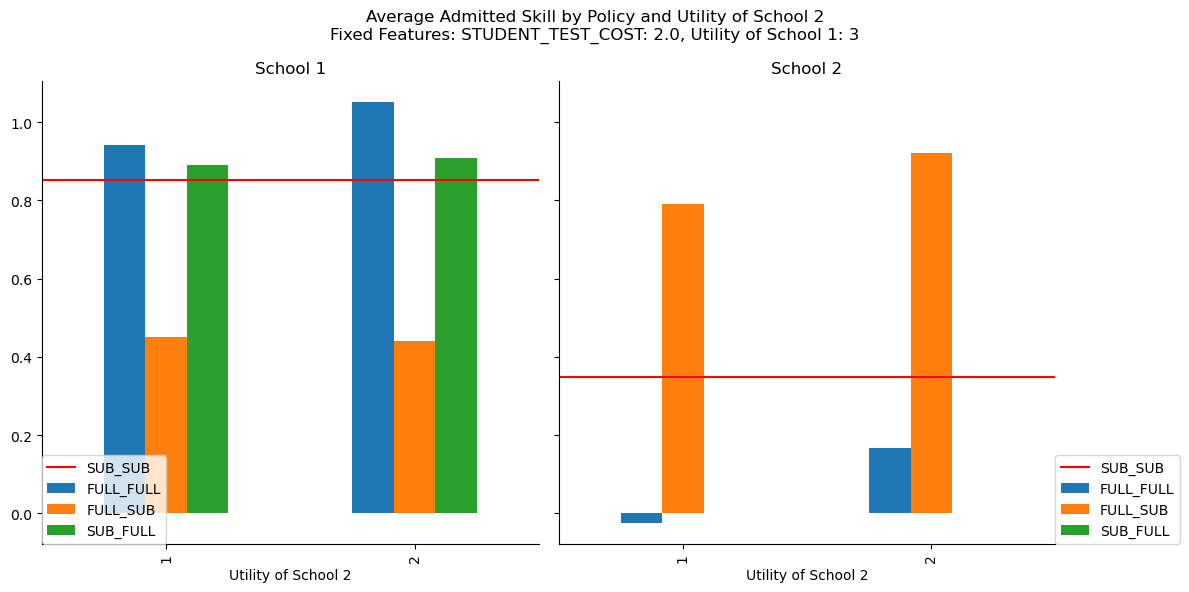

In [126]:
# Example usage
target_utility_a = results_df.UTILITY_a.unique()[1]
target_utility_b = results_df.UTILITY_b.unique()[1]
target_test_cost = np.sort(results_df.STUDENT_TEST_COST.unique())[1]
feature_to_vary = "UTILITY_b"

plot_avg_admitted_skill_by_policy(
    results_df=results_df,
    sub_sub_results=sub_sub_results,
    feature_to_vary=feature_to_vary,
    target_values={#'UTILITY_b': target_utility_b, 
                   'STUDENT_TEST_COST': target_test_cost,
                   'UTILITY_a': target_utility_a,
                   },
)

### Heatmap of payoff matrix

In [ ]:
target_utility_a = 3
target_utility_b = 2
target_test_cost = 2

results_a, results_b = filter_results_by_target_values(
                                            results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values={'UTILITY_b': target_utility_b, 
                                                        'STUDENT_TEST_COST': target_test_cost,
                                                        'UTILITY_a': target_utility_a,
                                                        },
                                            )

In [140]:
results_a = results_a[results_a["Policy"] != "SUB_SUB_nonstrategic_code"]
results_b = results_b[results_b["Policy"] != "SUB_SUB_nonstrategic_code"]



In [141]:

# Extract the action parts from the policy names
results_a['Action_A'] = results_a['Policy'].apply(lambda x: x.split('_')[0])
results_a['Action_B'] = results_a['Policy'].apply(lambda x: x.split('_')[1])
matrix_a = results_a.pivot(index='Action_A', columns='Action_B',
                         values=0)

# Extract the action parts from the policy names
results_b['Action_A'] = results_b['Policy'].apply(lambda x: x.split('_')[0])
results_b['Action_B'] = results_b['Policy'].apply(lambda x: x.split('_')[1])
matrix_b = results_b.pivot(index='Action_A', columns='Action_B',
                         values=0)



/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


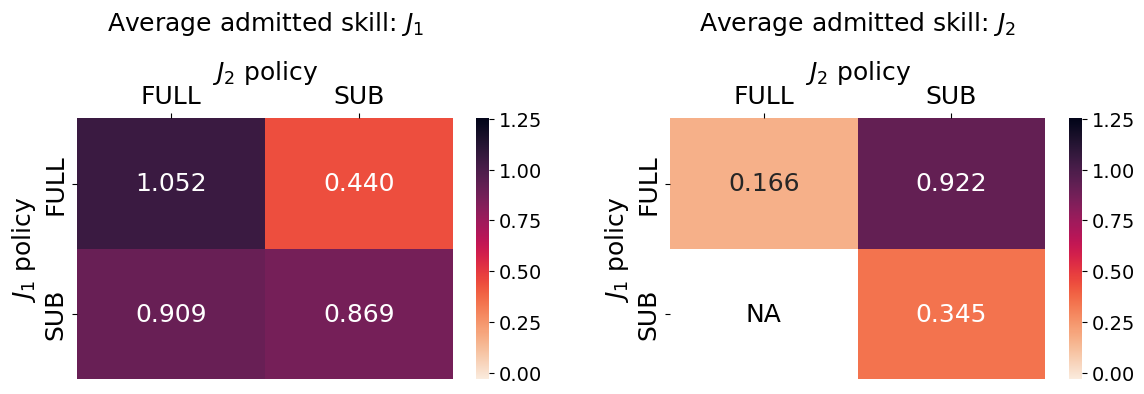

In [132]:
# Create heatmap of matrix_a values
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot heatmap of matrix_a
epsilon = 0.2
vmin = min(matrix_a.min().min(), matrix_b.min().min()) - epsilon
vmax = max(matrix_a.max().max(), matrix_b.max().max()) + epsilon
sns.heatmap(matrix_a, annot=True, fmt='.3f', ax=ax1, vmin=vmin, vmax=vmax, 
            cmap=sns.cm.rocket_r, annot_kws={"size": 18}) 
ax1.set_title("Average admitted skill: $J_1$", fontsize=18, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("$J_2$ policy", fontsize=18)
ax1.xaxis.tick_top()
ax1.set_ylabel("$J_1$ policy", fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)



# Plot heatmap of matrix_b
mask = matrix_b.isnull()
sns.heatmap(matrix_b, annot=True, fmt='.3f', ax=ax2, vmin=vmin, vmax=vmax,
            cmap=sns.cm.rocket_r, annot_kws={"size": 18}, mask=mask
            )
# Get the colorbars from both heatmaps
colorbar1 = ax1.collections[0].colorbar
colorbar2 = ax2.collections[0].colorbar

# Set font size for colorbar tick labels
colorbar1.ax.tick_params(labelsize=14)
colorbar2.ax.tick_params(labelsize=14)




# # Customize the appearance of NA cells
# Create a mask for NA values
sns.heatmap(matrix_b, mask=~mask, cmap=['grey'], cbar=False, ax=ax2)
# Annotate NaN cells with "NA"
for i in range(matrix_b.shape[0]):
    for j in range(matrix_b.shape[1]):
        if mask.iloc[i, j]:
            ax2.text(j + 0.5, i + 0.5, 'NA', ha='center', va='center', color='black', fontsize=18)

ax2.set_title("Average admitted skill: $J_2$", fontsize=18, pad=20)
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.set_xlabel("$J_2$ policy", fontsize=18)
ax2.set_ylabel("$J_1$ policy", fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.subplots_adjust(wspace=10)

plt.tight_layout()
plt.savefig(fig_directory + "avg_skill_heatmap_utila{}_utilb{}_cost{}.png".format(
    target_utility_a, target_utility_b, target_test_cost), 
            dpi=300)

### Plot with utility_a = 3, utility_b = 2, test_cost = 0.5

In [ ]:

target_utility_a = 3
target_utility_b = 2
target_test_cost = 0.5

results_a, results_b = filter_results_by_target_values(
                                            results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values={'UTILITY_b': target_utility_b, 
                                                        'STUDENT_TEST_COST': target_test_cost,
                                                        'UTILITY_a': target_utility_a,
                                                        },
                                            )

results_a = results_a.reset_index()
results_b = results_b.reset_index()


# Extract the action parts from the policy names
results_a['Action_A'] = results_a['Policy'].apply(lambda x: x.split('_')[0])
results_a['Action_B'] = results_a['Policy'].apply(lambda x: x.split('_')[1])
matrix_a = results_a.pivot(index='Action_A', columns='Action_B',
                         values=0)

# Extract the action parts from the policy names
results_b['Action_A'] = results_b['Policy'].apply(lambda x: x.split('_')[0])
results_b['Action_B'] = results_b['Policy'].apply(lambda x: x.split('_')[1])
matrix_b = results_b.pivot(index='Action_A', columns='Action_B',
                         values=0)

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


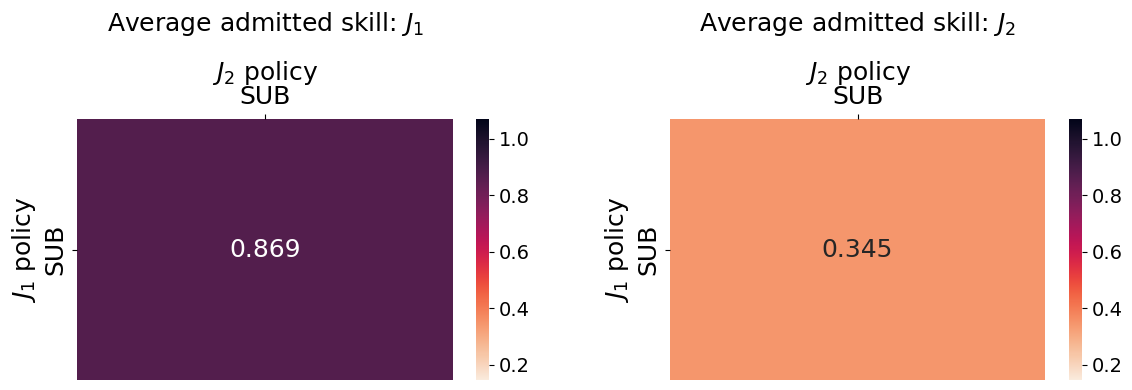

In [135]:
# Create heatmap of matrix_a values
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot heatmap of matrix_a
epsilon = 0.2
vmin = min(matrix_a.min().min(), matrix_b.min().min()) - epsilon
vmax = max(matrix_a.max().max(), matrix_b.max().max()) + epsilon
sns.heatmap(matrix_a, annot=True, fmt='.3f', ax=ax1, vmin=vmin, vmax=vmax, 
            cmap=sns.cm.rocket_r, annot_kws={"size": 18}) 
ax1.set_title("Average admitted skill: $J_1$", fontsize=18, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("$J_2$ policy", fontsize=18)
ax1.xaxis.tick_top()
ax1.set_ylabel("$J_1$ policy", fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)

# Plot heatmap of matrix_b
mask = matrix_b.isnull()
sns.heatmap(matrix_b, annot=True, fmt='.3f', ax=ax2, vmin=vmin, vmax=vmax,
            cmap=sns.cm.rocket_r, annot_kws={"size": 18}, mask=mask
            #na_color="grey", 
            #annot_kws_na={"label": "NA"}
            )



# Get the colorbars from both heatmaps
colorbar1 = ax1.collections[0].colorbar
colorbar2 = ax2.collections[0].colorbar

# Set font size for colorbar tick labels
colorbar1.ax.tick_params(labelsize=14)
colorbar2.ax.tick_params(labelsize=14)


# # Customize the appearance of NA cells
# Create a mask for NA values
sns.heatmap(matrix_b, mask=~mask, cmap=['grey'], cbar=False, ax=ax2)
# Annotate NaN cells with "NA"
for i in range(matrix_b.shape[0]):
    for j in range(matrix_b.shape[1]):
        if mask.iloc[i, j]:
            ax2.text(j + 0.5, i + 0.5, 'NA', ha='center', va='center', color='black', fontsize=18)

ax2.set_title("Average admitted skill: $J_2$", fontsize=18, pad=20)
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.set_xlabel("$J_2$ policy", fontsize=18)
ax2.set_ylabel("$J_1$ policy", fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.subplots_adjust(wspace=10)

plt.tight_layout()
# plt.savefig(fig_directory + "avg_skill_heatmap_utila{}_utilb{}_cost{}.png".format(
#     target_utility_a, target_utility_b, target_test_cost), 
#             dpi=300)

### Appendix figures


In [1107]:

target_utility_a = 3
target_utility_b = 2
target_test_cost = 1.5

results_a, results_b = filter_results_by_target_values(
                                            results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values={'UTILITY_b': target_utility_b, 
                                                        'STUDENT_TEST_COST': target_test_cost,
                                                        'UTILITY_a': target_utility_a,
                                                        },
                                            )

results_a = results_a.reset_index()
results_b = results_b.reset_index()

results_a = results_a[results_a["Policy"] != "SUB_SUB_nonstrategic_code"]
results_b = results_b[results_b["Policy"] != "SUB_SUB_nonstrategic_code"]

# Extract the action parts from the policy names
results_a['Action_A'] = results_a['Policy'].apply(lambda x: x.split('_')[0])
results_a['Action_B'] = results_a['Policy'].apply(lambda x: x.split('_')[1])
matrix_a = results_a.pivot(index='Action_A', columns='Action_B',
                         values=0)

# Extract the action parts from the policy names
results_b['Action_A'] = results_b['Policy'].apply(lambda x: x.split('_')[0])
results_b['Action_B'] = results_b['Policy'].apply(lambda x: x.split('_')[1])
matrix_b = results_b.pivot(index='Action_A', columns='Action_B',
                         values=0)

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_15196/1824059421.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df_a = temp_df_a.append(
/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_15196/1824059421.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df_b = temp_df_b.append(pd.Series({0:sub_sub_results['avgadmittedskill_school_b'].mean(),


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


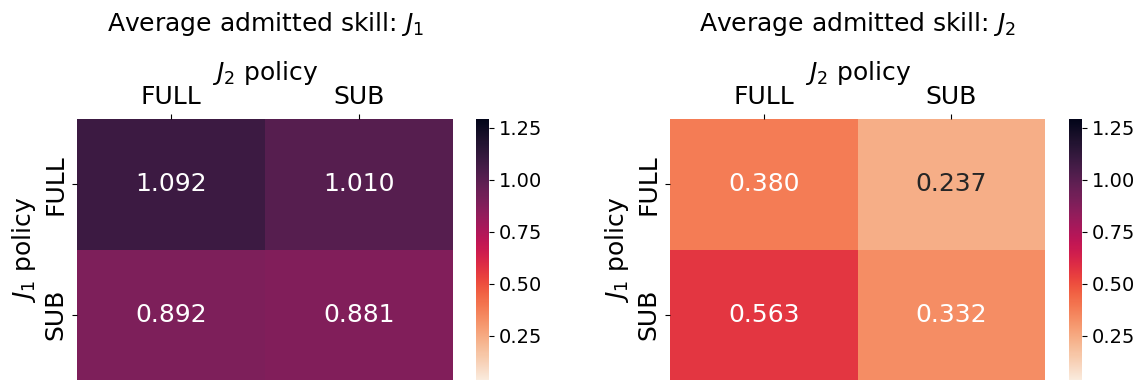

In [1109]:
# Create heatmap of matrix_a values
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot heatmap of matrix_a
epsilon = 0.2
vmin = min(matrix_a.min().min(), matrix_b.min().min()) - epsilon
vmax = max(matrix_a.max().max(), matrix_b.max().max()) + epsilon
sns.heatmap(matrix_a, annot=True, fmt='.3f', ax=ax1, vmin=vmin, vmax=vmax, 
            cmap=sns.cm.rocket_r, annot_kws={"size": 18}) 
ax1.set_title("Average admitted skill: $J_1$", fontsize=18, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("$J_2$ policy", fontsize=18)
ax1.xaxis.tick_top()
ax1.set_ylabel("$J_1$ policy", fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)

# Plot heatmap of matrix_b
mask = matrix_b.isnull()
sns.heatmap(matrix_b, annot=True, fmt='.3f', ax=ax2, vmin=vmin, vmax=vmax,
            cmap=sns.cm.rocket_r, annot_kws={"size": 18}, mask=mask
            #na_color="grey", 
            #annot_kws_na={"label": "NA"}
            )



# Get the colorbars from both heatmaps
colorbar1 = ax1.collections[0].colorbar
colorbar2 = ax2.collections[0].colorbar

# Set font size for colorbar tick labels
colorbar1.ax.tick_params(labelsize=14)
colorbar2.ax.tick_params(labelsize=14)


# # Customize the appearance of NA cells
# Create a mask for NA values
sns.heatmap(matrix_b, mask=~mask, cmap=['grey'], cbar=False, ax=ax2)
# Annotate NaN cells with "NA"
for i in range(matrix_b.shape[0]):
    for j in range(matrix_b.shape[1]):
        if mask.iloc[i, j]:
            ax2.text(j + 0.5, i + 0.5, 'NA', ha='center', va='center', color='black', fontsize=18)

ax2.set_title("Average admitted skill: $J_2$", fontsize=18, pad=20)
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.set_xlabel("$J_2$ policy", fontsize=18)
ax2.set_ylabel("$J_1$ policy", fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.subplots_adjust(wspace=10)

plt.tight_layout()
# plt.savefig(fig_directory + "avg_skill_heatmap_utila{}_utilb{}_cost{}.png".format(
#     target_utility_a, target_utility_b, target_test_cost), 
#             dpi=300)